In [40]:
import numpy as np
from torchvision.datasets import CocoDetection
import datetime
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import sys 
sys.path.append("/home/tyfei/cyroem")
import utils
import torch
import importlib 
importlib.reload(utils)
import modules
import pycocotools.coco
import pycocotools.mask
import torchvision.transforms.v2 as transforms
from transformers import DetrConfig, DetrForObjectDetection, DetrImageProcessor, DetrForSegmentation, ConditionalDetrForObjectDetection,ConditionalDetrConfig,ConditionalDetrForSegmentation

In [114]:
data = utils.readTomogram("/data/transformer_training_data/sjht0078_flipY.mrc")
l, h, w = data.shape
data.shape

(500, 1024, 1024)

In [ ]:
dataset1 = modules.CocoDetection("/home/feity/cryoem/dataset/Mean10", 
                        "/home/feity/cryoem/dataset/npy_annotations.pkl",
                        is_npy=True, transform=utils.getConstantTransform(), require_mask=True, filter_class=[1,2,4,5,6,7,8,9,10,11,12])


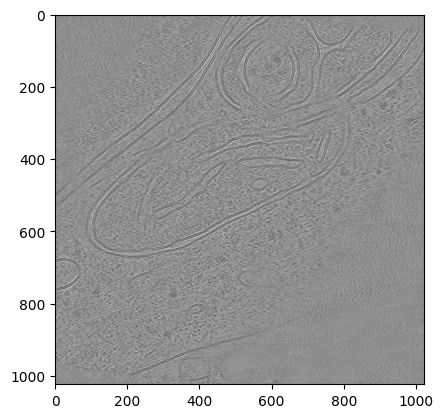

In [11]:
plt.imshow(data[280], cmap='gray')

In [115]:
for i in range(0, 500, 10):
    # images.append(np.array(data[i]))
    res = np.zeros((3, h, w))
    res[1] = data[i] 
    res[0] = np.mean(data[max(0, i-10):max(i, 1)], axis=0)
    res[2] = np.mean(data[i:i+10], axis=0)
    res -= np.min(res) 
    res /= np.max(res)
    np.save("/home/feity/cryoem/dataset/sjht0078_ori/%s_%i.npy"%("sjht", i), res)

In [163]:
a =np.load("/home/feity/cryoem/dataset/sjht0078_ori/sjht_280.npy")

In [164]:
# t = utils.getConstantTransform()
t = transforms.Compose([
    transforms.Resize((800, 800)),
    # transforms.ToTensor()
])
a = torch.tensor(a, dtype=torch.float32)
a = t(a)
a = a.unsqueeze(0)

In [165]:
a.shape

torch.Size([1, 3, 800, 800])

In [174]:
model = ConditionalDetrForObjectDetection.from_pretrained(
    "microsoft/conditional-detr-resnet-50",
    num_labels=14,
    ignore_mismatched_sizes=True,
)
# pars = torch.load("/home/feity/cryoem/checkpoints/conditional_detr_3_transform_3600/epoch=3296-validate_loss=2.04.ckpt")
pars = torch.load("/home/feity/cryoem/checkpoints/conditional_detr_without3_transform_3600/epoch=2655-validate_loss=1.24.ckpt")
model = modules.Detr(lr=1e-4, model=model, lr_backbone=1e-5, weight_decay=1e-4)
model.load_state_dict(pars["state_dict"])

Some weights of ConditionalDetrForObjectDetection were not initialized from the model checkpoint at microsoft/conditional-detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.bias: found shape torch.Size([91]) in the checkpoint and torch.Size([14]) in the model instantiated
- class_labels_classifier.weight: found shape torch.Size([91, 256]) in the checkpoint and torch.Size([14, 256]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_2894798/3733725718.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for

<All keys matched successfully>

In [166]:
a

tensor([[[[0.5585, 0.5692, 0.5719,  ..., 0.5530, 0.5659, 0.5764],
          [0.5490, 0.5579, 0.5733,  ..., 0.5560, 0.5620, 0.5672],
          [0.5381, 0.5507, 0.5742,  ..., 0.5625, 0.5636, 0.5563],
          ...,
          [0.5629, 0.5498, 0.5380,  ..., 0.5457, 0.5380, 0.5368],
          [0.5636, 0.5469, 0.5411,  ..., 0.5596, 0.5469, 0.5422],
          [0.5597, 0.5444, 0.5390,  ..., 0.5731, 0.5674, 0.5494]],

         [[0.5579, 0.5614, 0.6034,  ..., 0.5441, 0.5514, 0.5783],
          [0.5283, 0.5439, 0.5830,  ..., 0.5508, 0.5577, 0.5708],
          [0.5065, 0.5171, 0.5575,  ..., 0.5630, 0.5701, 0.5710],
          ...,
          [0.5589, 0.5633, 0.5436,  ..., 0.5657, 0.5595, 0.5519],
          [0.5609, 0.5493, 0.5456,  ..., 0.5616, 0.5490, 0.5474],
          [0.5271, 0.5412, 0.5339,  ..., 0.5600, 0.5517, 0.5665]],

         [[0.5501, 0.5651, 0.5909,  ..., 0.5511, 0.5495, 0.5544],
          [0.5407, 0.5403, 0.5524,  ..., 0.5542, 0.5610, 0.5665],
          [0.5332, 0.5196, 0.5198,  ..., 0

In [175]:
model = model.cpu()
with torch.no_grad():
    outputs = model(pixel_values = a, pixel_mask=torch.ones((1, 800, 800)))

In [176]:
importlib.reload(utils)
target_sizes = [(800, 800)]
results = utils.postSegmentationTreatment(outputs, 0.65, target_sizes, mask_threshold=None)
result = results[0]

In [177]:
keep = utils.bbnms(0.01, result["boxes"], result["scores"], result["labels"])
for i in result:
    result[i] = result[i][keep]

In [178]:
result

{'scores': tensor([0.9441, 0.8952, 0.7273, 0.6613, 0.8863, 0.8237, 0.7881]),
 'labels': tensor([1, 1, 1, 1, 4, 4, 4]),
 'boxes': tensor([[405.7482, 620.9508, 534.2930, 750.4200],
         [639.7646, 613.6543, 790.1403, 781.0740],
         [ 43.5735, 275.2923, 527.6747, 479.1409],
         [725.1010, 413.9383, 771.9540, 432.5683],
         [160.4515, 226.2138, 204.9274, 242.8782],
         [217.5833, 363.5624, 269.8899, 389.6268],
         [294.0392,   3.6770, 338.6938,  21.1055]])}

In [179]:
def drawannotation(image, target):
    class_names = [str(i) for i in range(14)]
    int_colors = plt.cm.get_cmap("tab20", len(class_names))
    # import matplotlib.pyplot as plt
    from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

    if isinstance(image, torch.Tensor):
        image = image.numpy()
    if np.max(image) < 10:
        image -= np.min(image)
        image /= np.max(image)
        image = torch.tensor(image * 255).type(torch.uint8)

    if "masks" in target:
        annotated_tensor = draw_segmentation_masks(
            image=image,
            masks=target["masks"],
            alpha=0.3,
            colors=[int_colors(i) for i in [class_names.index(label) for label in target["names"]]]
        )
    else:
        annotated_tensor = image
        annotated_tensor = torch.tensor(annotated_tensor, dtype=torch.uint8)
    # Annotate the sample image with labels and bounding boxes
    # if "names" in target:
    annotated_tensor = draw_bounding_boxes(
        image=annotated_tensor,
        boxes=target["bboxes"],
        labels=target["names"] if "names" in target else target["labels"],
        font_size=30,
        colors=[class_names.index(label) for label in target["names"]]
    )
    res = annotated_tensor.numpy()
    plt.imshow(np.moveaxis(res, 0, -1))

In [180]:
int_colors = plt.cm.get_cmap("tab20", 14)
int_colors(0)

/tmp/ipykernel_2894798/3909934053.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  int_colors = plt.cm.get_cmap("tab20", 14)


(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0)

/tmp/ipykernel_2894798/3837870911.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  int_colors = plt.cm.get_cmap("tab20", len(class_names))
/tmp/ipykernel_2894798/3837870911.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  annotated_tensor = torch.tensor(annotated_tensor, dtype=torch.uint8)


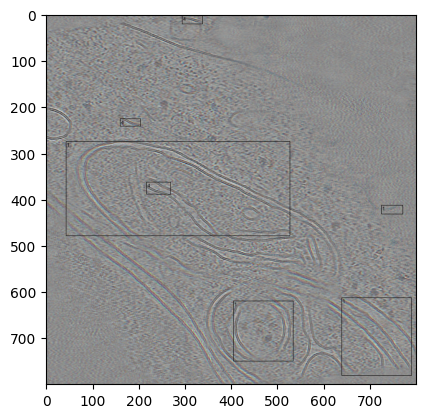

In [181]:
img = a[0]
t = utils.toTarget(result, img.shape[1:])
importlib.reload(utils)
drawannotation(img.cpu().numpy(), t)


In [182]:
t

{'labels': tensor([1, 1, 1, 1, 4, 4, 4]),
 'bboxes': BoundingBoxes([[405.7482, 620.9508, 534.2930, 750.4200],
                [639.7646, 613.6543, 790.1403, 781.0740],
                [ 43.5735, 275.2923, 527.6747, 479.1409],
                [725.1010, 413.9383, 771.9540, 432.5683],
                [160.4515, 226.2138, 204.9274, 242.8782],
                [217.5833, 363.5624, 269.8899, 389.6268],
                [294.0392,   3.6770, 338.6938,  21.1055]], format=BoundingBoxFormat.XYXY, canvas_size=torch.Size([800, 800])),
 'names': ['1', '1', '1', '1', '4', '4', '4']}

/home/feity/cryoem/utils.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  annotated_tensor = torch.tensor(annotated_tensor, dtype=torch.uint8)
/home/feity/anaconda3/envs/pytorch/lib/python3.12/site-packages/torchvision/utils.py:225: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


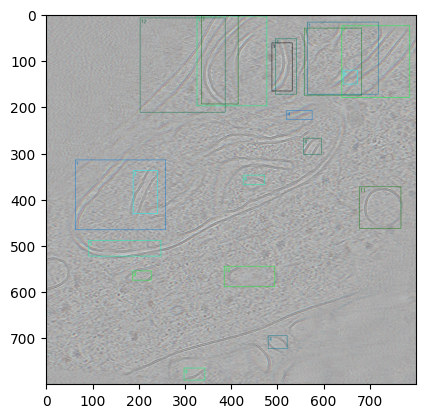

In [ ]:
img = a[0]
t = utils.toTarget(result, img.shape[1:])
importlib.reload(utils)
utils.drawannotation(img.cpu().numpy(), t)
